###Import Required Modules

In [3]:
import pandas as pd
import re
import json
import matplotlib.pyplot as plt
import numpy as np
import cv2
import json
import os
from sklearn.cluster import KMeans
from dataclasses import dataclass
from typing import List
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

### Downloading COCO Annotations Dataset

In [2]:
print(f"os.getcwd()={os.getcwd()}")

# download annotation from https://cocodataset.org/#download: 2017 Train/Val annotations [241MB]
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip 'annotations_trainval2017.zip'
!ls -la /content/annotations

os.getcwd()=/content
--2021-08-07 17:44:08--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.76.188
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.76.188|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  35.0MB/s    in 7.5s    

2021-08-07 17:44:16 (32.3 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]

Archive:  annotations_trainval2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2017.json  
  inflating: annotations/person_keypoints_val2017.json  
total 814896
drwxr-xr-x 2 root root      4096 Aug

### Reading COCO-2017 Annotations Dataset

In [8]:

with open('/content/annotations/instances_train2017.json', "r") as train2017_file:
  train2017_data:dict = json.load(train2017_file)

images:list = train2017_data["images"]
categories:list = train2017_data["categories"]
annotations:list = train2017_data["annotations"]

In [9]:
id_to_name:dict = {}
for category in categories:
    id_to_name[category['id']] = category['name']

### Mapping Class ID to Names

In [10]:

name_to_annot_count:dict = {}
for annot in annotations:
    cat_name = id_to_name[annot['category_id']]
    if not name_to_annot_count.get(cat_name): name_to_annot_count[cat_name] = 0  # initialize with 0 for the very first time.
    name_to_annot_count[cat_name] += 1

sorted_cats = [ k for k, v in sorted(name_to_annot_count.items(), reverse=True, key=lambda item: item[1]) ]
sorted_cat_counts = [ v for k, v in sorted(name_to_annot_count.items(), reverse=True, key=lambda item: item[1]) ]  # sort in descending order


### Num of BBox for each class

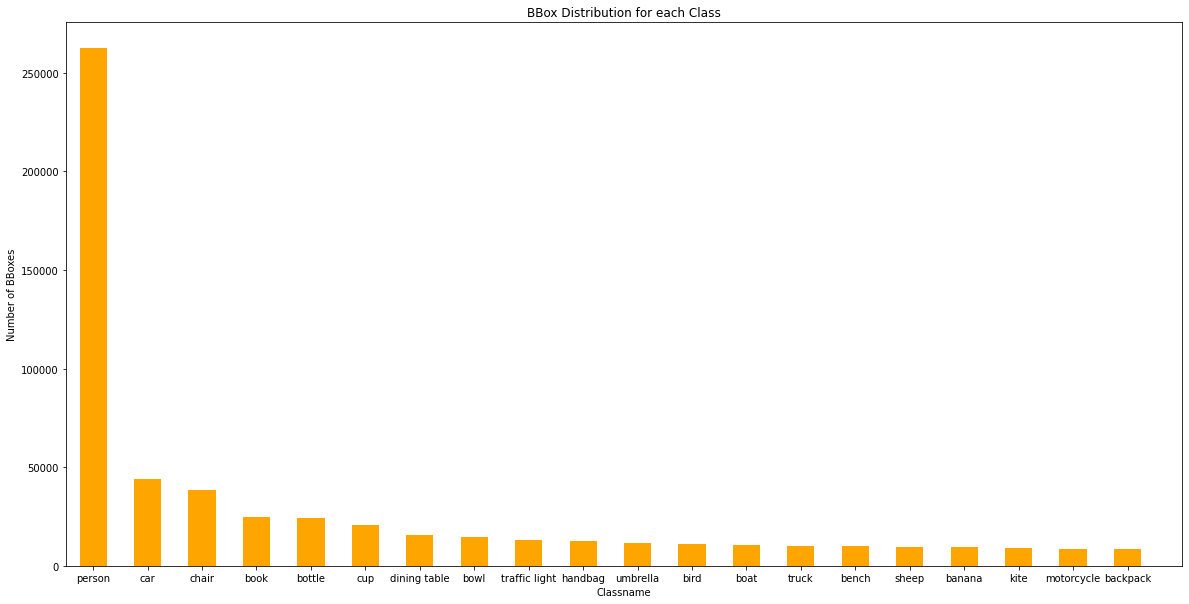

In [19]:
top_n = 20
plt.figure(figsize=(top_n,10))   # figsize : (float, float), optional, default: None; width, height in inches. If not provided, defaults to figure.figsize = [6.4, 4.8].
plt.bar(np.arange(top_n),sorted_cat_counts[:top_n], width=0.5, tick_label=sorted_cats[:top_n], color='orange')   
#plt.xticks(rotation=90) 
plt.xlim(-0.5,top_n)
plt.xlabel('Classname')
plt.ylabel('Number of BBoxes')
plt.title('BBox Distribution for each Class')
plt.show()

### Setting up Normalized BBox Width and Height for KMeans

In [21]:

images_df = pd.DataFrame(images, columns = ['id', 'file_name', 'width', 'height'])
annotations_df = pd.DataFrame(annotations, columns = ['id', 'bbox'])

annotation_map_df = pd.concat([images_df, annotations_df], 1)[['file_name', 'width', 'height', 'bbox']]

box_df =pd.DataFrame(annotation_map_df['bbox'].values.tolist(), columns =['x', 'y', 'box_width', 'box_height'])
annotation_map_df = pd.concat([annotation_map_df, box_df], 1)
annotation_map_df = annotation_map_df.drop('bbox', axis =1)


#Normalize the Box Dimensions based on Image Height and Width
annotation_map_df['x'] = annotation_map_df['x'] / annotation_map_df['width']
annotation_map_df['y'] = annotation_map_df['y'] / annotation_map_df['height']
annotation_map_df['box_width'] = annotation_map_df['box_width'] / annotation_map_df['width']
annotation_map_df['box_height'] = annotation_map_df['box_height'] / annotation_map_df['height']


annotation_map_df = annotation_map_df.dropna()
annotation_map_df.isnull().any()

bb_width_height_arr = annotation_map_df[["box_width", "box_height"]].to_numpy()
bb_width_height_arr.shape

(118287, 2)

### BBox Width and Height Scatter Plot

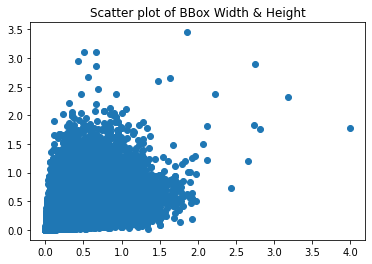

In [22]:
plt.scatter(bb_width_height_arr[:,0], bb_width_height_arr[:,1])
plt.title("Scatter plot of BBox Width & Height")
plt.show()

### Perform KMeans Clustering on BBox

In [23]:
def compute_IOU(x,centroids):
    IoUs = []
    for centroid in centroids:
            bb_w, bb_h = x # bounding box's w, h
            c_w,c_h = centroid # anchor box w, h
           
            if c_w>=bb_w and c_h>=bb_h: #anchor box surrounded by bounding box
              iou = bb_w*bb_h/(c_w*c_h)
            elif c_w>=bb_w and c_h<=bb_h: #anchor
              iou = bb_w*c_h/(bb_w*bb_h + (c_w-bb_w)*c_h)
            elif c_w<=bb_w and c_h>=bb_h: #anchor box is taller than bounding box in the width 
              iou = c_w*bb_h/(bb_w*bb_h + c_w*(c_h-bb_h))
            else: #bounding box surrounded by anchor means both w,h are bigger than c_w and c_h respectively
              iou = (c_w*c_h)/(bb_w*bb_h)
            IoUs.append(iou) 
    return np.array(IoUs)  # return the IOU between this bounding box and each of the anchor boxes/centroids

def compute_avg_IOU(X, centroids):
    n,d = X.shape
    sum_of_maxIOU = 0.
    for i in range(X.shape[0]):   # iterate throught each bounding  box..
        sum_of_maxIOU+= max(compute_IOU(X[i],centroids)) #compute the IOU for each anchor box; take the max; add it to the maxIOU
    return sum_of_maxIOU / X.shape[0]   # compute the average: sum / number of bounding boxes

def plot_anchor_boxes(num_of_clusters, centroids):
    xdata = np.array([0.5]*len(centroids))
    ydata = np.array([0.5]*len(centroids))
    xerror = np.array([list(np.exp(centroids[:, 0])/2)]*2)
    yerror = np.array([list(np.exp(centroids[:, 1])/2)]*2)
    errorboxes = []
    for x, y, xe, ye in zip(xdata, ydata, xerror.T, yerror.T):
        rect = Rectangle((x - xe[0], y - ye[0]), xe.sum(), ye.sum())
        errorboxes.append(rect)

    pc = PatchCollection(errorboxes, facecolor='None', alpha=1, edgecolor='b')
    fig, ax = plt.subplots(1)

    ax.add_collection(pc)
    plt.title(f'Anchor Boxes for number of clusters = {num_of_clusters}')
    artists = plt.errorbar(xdata, ydata, xerr=xerror, yerr=yerror, fmt='None', ecolor='None')


@dataclass
class KMeansResult:
    num_of_clusters:int
    cluster_centers:List[List[float]]
    pred_y:List[int]
    avg_IOU:float


kMeansResults:list = [None,None,None]
num_cluster_range = range(3,7)   # compute kmeans cluster for number of clusters = 3 to 6
for i in num_cluster_range:
  kmeans = KMeans(n_clusters=i, init='k-means++', random_state=10)
  pred_y = kmeans.fit_predict(bb_width_height_arr)
  avg_iou = compute_avg_IOU(bb_width_height_arr, kmeans.cluster_centers_)
  kMeansResults.append(KMeansResult(i, kmeans.cluster_centers_,pred_y, avg_iou))

print(kMeansResults)

[None, None, None, KMeansResult(num_of_clusters=3, cluster_centers=array([[0.29170448, 0.41593413],
       [0.07272931, 0.09557326],
       [0.73640768, 0.79335423]]), pred_y=array([1, 1, 0, ..., 1, 1, 1], dtype=int32), avg_IOU=0.3896668733873761), KMeansResult(num_of_clusters=4, cluster_centers=array([[0.06698513, 0.08807545],
       [0.88730536, 0.55921447],
       [0.25906547, 0.36027513],
       [0.45153117, 0.92247932]]), pred_y=array([0, 0, 2, ..., 0, 0, 0], dtype=int32), avg_IOU=0.40954508366064235), KMeansResult(num_of_clusters=5, cluster_centers=array([[0.213444  , 0.2620148 ],
       [0.86614312, 0.49339784],
       [0.05647555, 0.07617373],
       [0.31349763, 0.60741733],
       [0.63141078, 1.07827102]]), pred_y=array([0, 2, 0, ..., 2, 2, 2], dtype=int32), avg_IOU=0.44314776940260264), KMeansResult(num_of_clusters=6, cluster_centers=array([[0.05418414, 0.07093342],
       [0.2636181 , 0.6031903 ],
       [0.17661715, 0.24701394],
       [0.56188941, 1.05368201],
       [1.

### Plot of Num of Clusters vs Avg of Max IoU

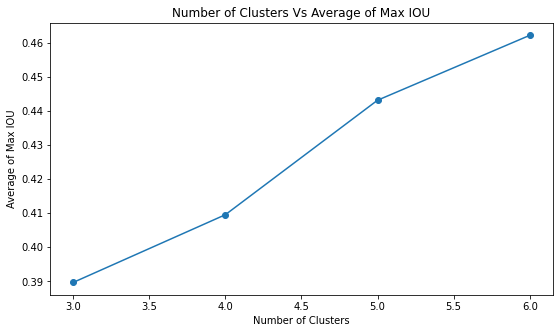

In [24]:
fig = plt.figure(figsize=(9, 5))
plt.plot(num_cluster_range, [kMeansResult.avg_IOU for kMeansResult in kMeansResults[3:] ], marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Avg of Max IOU')
plt.title("Number of Clusters Vs Avg of Max IOU")
plt.show()

### Anchor Boxes for Clusters 3, 4, 5, 6

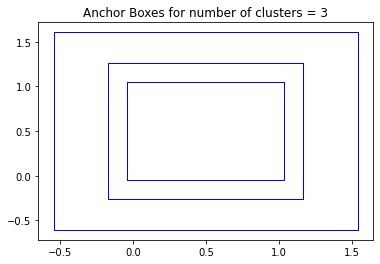

In [25]:
plot_anchor_boxes(kMeansResults[3].num_of_clusters, kMeansResults[3].cluster_centers)

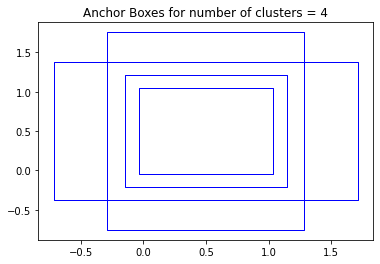

In [30]:
plot_anchor_boxes(kMeansResults[4].num_of_clusters, kMeansResults[4].cluster_centers)

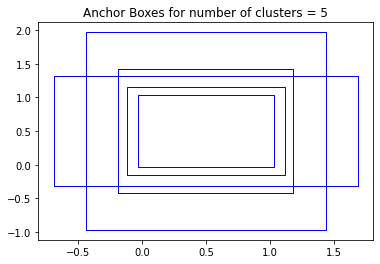

In [31]:
plot_anchor_boxes(kMeansResults[5].num_of_clusters, kMeansResults[5].cluster_centers)

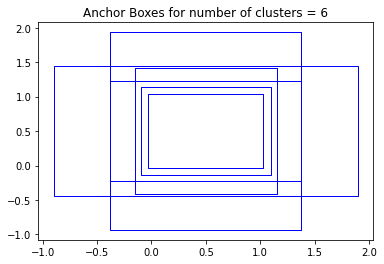

In [32]:
plot_anchor_boxes(kMeansResults[6].num_of_clusters, kMeansResults[6].cluster_centers)